In [1349]:
from collections.abc import Callable
from numbers import Number

import cma
import numpy as np
import plotly.graph_objects as go
import scipy as sp

In [1350]:
f = cma.ff.rosen  # we could use `functools.partial(cma.ff.elli, cond=1e4)` to change the condition number to 1e4
x0 = 8 * [2]  # initial solution
sigma0 = 1  # initial standard deviation to sample new solutions
pop_size = 100

(50_w,100)-aCMA-ES (mu_w=27.0,w_1=8%) in dimension 8 (seed=1101686, Mon Oct 20 06:44:03 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]


    1    100 2.115076222250622e+03 1.0e+00 1.16e+00  1e+00  1e+00 0:00.0
    2    200 1.437388992162993e+03 1.3e+00 1.48e+00  1e+00  1e+00 0:00.0
    3    300 1.166418850774718e+03 1.5e+00 1.91e+00  1e+00  2e+00 0:00.0
  100  10000 2.972698729000493e-03 5.9e+01 7.90e+01  2e-03  7e-02 0:00.2
  163  16300 1.054448713300961e-13 5.8e+01 1.31e+00  1e-08  3e-07 0:00.3
termination on tolfun=1e-11
final/bestever f-value = 1.054449e-13 1.054449e-13 after 16300/16256 evaluations
incumbent solution: [1., 1., 1., 1., 1.00000001, 1.00000001, 1.00000002, 1.00000004]
std deviation: [1.10094598e-08, 1.24240742e-08, 1.50077414e-08, 2.50330662e-08, 4.50472076e-08, 8.74788966e-08, 1.75610548e-07, 3.49280446e-07]


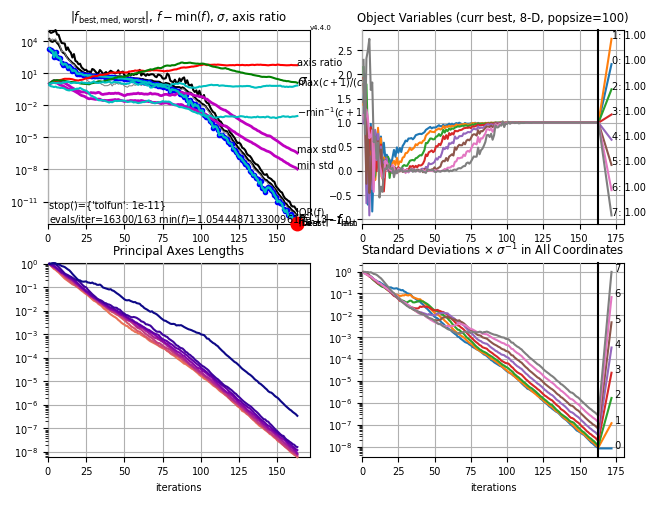

In [1351]:
opts = cma.CMAOptions()
opts.set("popsize", pop_size)
es = cma.CMAEvolutionStrategy(x0, sigma0, opts)
history_cma = []
while not es.stop():
    X = es.ask()
    F = [f(x) for x in X]
    history_cma.append(es.best.f)
    es.tell(X, F)
    es.disp()
    es.logger.add()  # write data for plotting
es.result_pretty()
es.plot();  # see below

In [1352]:
from numpy import array, dot, outer, trace
from scipy.linalg import expm

In [ ]:
d = len(x0)
mu = x0
sigma_log = 0.0
B = np.eye(d)
population_size = pop_size
rng = np.random.default_rng(42)

weights = np.linspace(1, -8, population_size)
weights = np.maximum(0, weights)
weights /= np.sum(weights)
weights -= 1 / population_size


weights_limit = np.log(0.5 * population_size + 1)
weights = np.array([weights_limit - np.log(1 + i) for i in range(population_size)])
weights = np.maximum(0, weights)
weights /= np.sum(weights)
weights -= 1 / population_size


eta_mu = 1
eta_cov = 0.1

history_xnes = []
for _k in range(2000):
    pop = []
    for _i in range(population_size):
        zi = rng.normal(0, 1, size=d)
        xi = mu + B @ zi
        fxi = f(xi)
        pop.append((zi, xi, fxi))
    pop.sort(key=lambda p: p[2])
    history_xnes.append(pop[0][2])

    samples = np.array([zi for zi, _, _ in pop])
    d_mu = samples.T @ weights
    covGradient = dot(array([outer(s, s) - np.eye(d) for s in samples]).T, weights)
    dA = 0.5 * eta_cov * covGradient

    mu += eta_mu * B @ d_mu
    B = B @ expm(dA)

In [1354]:
weights = np.maximum(0, np.linspace(1, -8, population_size))
weights /= weights.sum()
weights -= 1 / population_size
# weights -= weights.mean()
mu_eff = (np.linalg.norm(weights, ord=1) / np.linalg.norm(weights, ord=2)) ** 2
weights.sum(), mu_eff, 0.3 * population_size

(np.float64(-1.0755285551056204e-16), np.float64(29.8450618458611), 30.0)

In [1355]:
weights_limit = np.log(0.5 * population_size + 1)
weights = np.array([weights_limit - np.log(1 + i) for i in range(population_size)])
weights = np.maximum(0, weights)
weights /= np.sum(weights)
weights -= 1 / population_size
mu_eff = (np.linalg.norm(weights, ord=1) / np.linalg.norm(weights, ord=2)) ** 2
weights.sum(), mu_eff, 0.3 * population_size

(np.float64(3.469446951953614e-18), np.float64(53.9036752391751), 30.0)

In [ ]:
rng = np.random.default_rng(42)

In [ ]:
def natural_evolution(
    f: Callable[[np.ndarray], float],
    x0: np.ndarray,
    sigma0: float | np.ndarray = 1.0,
    population_size: int | None = None,
    callback: Callable[[np.ndarray, np.ndarray], None] | None = None,
    eta_mu: float = 1.0,
    eta_sigma: float = 1.0,
    eta_cov: float = 1.0,
    path_damping: float = 1.0,
    tol_sigma_log: float = -20.0,
) -> np.ndarray:
    # check parameters
    x0 = np.asarray(x0, dtype=float)
    d = x0.size
    E = np.eye(d)
    if isinstance(sigma0, Number):
        sigma0 = np.full(d, sigma0, dtype=float)
    if sigma0.ndim == 1:
        sigma0 = np.diag(sigma0)
    if population_size is None:
        population_size = 4 + int(3 * np.log(d))

    # construct monotonically decreasing weights
    weights = np.array([np.log1p(population_size / 2) - np.log1p(i) for i in range(population_size)])
    weights = np.maximum(0, weights)
    weights /= np.sum(weights)  # weights should sum to 1
    weights -= 1 / population_size  # subtract baseline for active adaptation

    # initialize variables
    mu = x0
    sigma = abs(np.linalg.det(sigma0)) ** (1 / d)
    sigma_log = np.log(sigma)
    covariance_sqrt = sigma0 / sigma
    path = np.zeros_like(mu)
    eta_path = min(1, 3 / d)
    mu_eff = 1 / (np.maximum(0, weights) ** 2).sum()
    path_factor = np.sqrt(eta_path * (2 - eta_path) * mu_eff)
    path_expectation = np.sqrt(2) * sp.special.gamma((d + 1) / 2) / sp.special.gamma(d / 2)

    while sigma_log > tol_sigma_log:
        # sample distribution
        sigma = np.exp(sigma_log)
        z = rng.normal(0, 1, (d, population_size))
        x = mu[:, np.newaxis] + sigma * dot(covariance_sqrt, z)

        # evaluate and report
        fx = np.array(list(map(f, x.T)))
        samples = z[:, fx.argsort()]
        if callback is not None:
            callback(x, fx)

        # calculate natural gradient
        delta_grad = samples @ weights
        M_grad = array([outer(s, s) - E for s in samples.T]).T @ weights
        sigma_grad = trace(M_grad) / d

        # take update step
        mu += eta_mu * sigma * covariance_sqrt @ delta_grad
        sigma_log += 0.5 * eta_sigma * sigma_grad
        covariance_update = 0.5 * eta_cov * (M_grad - sigma_grad * E)
        covariance_sqrt = covariance_sqrt @ expm(covariance_update)

        # adapt step size
        path = (1 - eta_path) * path + path_factor * delta_grad
        path_norm = np.linalg.norm(path)
        sigma_log += path_damping * eta_path * (path_norm / path_expectation - 1)

In [1358]:
history_ines = []


def cb(x, fx):
    history_ines.append(fx.min())


natural_evolution(f, x0, sigma0, population_size=pop_size, callback=cb)

In [1359]:
go.Figure(
    [
        go.Scatter(name="INES", x=list(range(len(history_ines))), y=history_ines),
        go.Scatter(name="XNES", x=list(range(len(history_xnes))), y=history_xnes),
        go.Scatter(name="CMA-ES", x=list(range(len(history_cma))), y=history_cma),
    ]
).update_yaxes(type="log")